In [13]:
# General
import numpy as np
import torch
import torch.nn.functional as F
from importlib import reload
from types import SimpleNamespace
import shap

# Custom
import utils
reload(utils)

import data
reload(data)

import train
reload(train)

import modules
reload(modules)
from modules import GCN, GCN_GNNExplainer, GCN_GraphSVX
from modules import GraphSAGE
from torch_geometric.data import DataLoader
import torch.optim as optim

import explanations
reload(explanations)
from explanations import LIME_explanation, SHAP_explanation

import GraphSVX_explainers
reload(GraphSVX_explainers)
from GraphSVX_explainers import GraphSVX, GraphLIME

%matplotlib inline


# Training model

In [14]:


hyperparameters = {'hidden_channels': 15,
                   'num_heads': 3,
                    'dropout': 0.2,
                    'lr': 0.001,
                    'epochs': 1000,
                    'beta': 0.9999,
                    'seed':1}
model, traindata, testdata, feature_names, target_names, running_train_loss, running_test_loss, accuracy = train.train_graphSAGE_foroptuna(hyperparameters, verbose = True)

n_sar_accs_train = traindata.y[traindata.y == 1].shape[0]
n_sar_accs_test = testdata.y[testdata.y == 1].shape[0]
print(f"Number of SARs in training set: {n_sar_accs_train} out of {traindata.y.shape[0]}")
print(f"Number of SARs in test set: {n_sar_accs_test} out of {testdata.y.shape[0]}")

epoch: 1, train_loss: 0.2932, test_loss: 0.2863010764122009, accuracy: 0.9512, balanced_accuracy: 0.5036, precision: 0.0401, recall: 0.0274, f0.9999: 0.0326
epoch: 10, train_loss: 0.2765, test_loss: 0.28353190422058105, accuracy: 0.9207, balanced_accuracy: 0.5055, precision: 0.0360, recall: 0.0639, f0.9999: 0.0461
epoch: 20, train_loss: 0.2609, test_loss: 0.26931124925613403, accuracy: 0.9170, balanced_accuracy: 0.5142, precision: 0.0441, recall: 0.0856, f0.9999: 0.0583
epoch: 30, train_loss: 0.2474, test_loss: 0.25233596563339233, accuracy: 0.9349, balanced_accuracy: 0.5162, precision: 0.0539, recall: 0.0709, f0.9999: 0.0613
epoch: 40, train_loss: 0.2361, test_loss: 0.23779462277889252, accuracy: 0.9507, balanced_accuracy: 0.5116, precision: 0.0606, recall: 0.0445, f0.9999: 0.0513
epoch: 50, train_loss: 0.2254, test_loss: 0.22441035509109497, accuracy: 0.9609, balanced_accuracy: 0.5074, precision: 0.0705, recall: 0.0251, f0.9999: 0.0370
epoch: 60, train_loss: 0.2136, test_loss: 0.2134

In [16]:
from sklearn.metrics import confusion_matrix
import numpy as np

model.eval()
with torch.no_grad():
    out = model.forward(testdata.x, testdata.edge_index)
    y_pred = out.cpu().numpy().argmax(axis=1)
    y_true = testdata.y.cpu().numpy()
    cm = confusion_matrix(y_true, y_pred)
    print(cm)

[[94720  2056]
 [ 1039  1951]]


In [17]:
def get_sar_prediction_ix(model, testdata):
    model.eval()
    with torch.no_grad():
        out = model.forward(testdata.x, testdata.edge_index)
        y_pred = out.argmax(dim=1)
        sar_prediction_ix = torch.where(y_pred == 1)[0]
    return sar_prediction_ix

sar_prediction_ix = get_sar_prediction_ix(model, testdata)
n_sar_prediction_ix = len(sar_prediction_ix)

print(f'Some of the {n_sar_prediction_ix} SAR prediction indices: {sar_prediction_ix[0:5].cpu().numpy()} ...')

Some of the 4059 SAR prediction indices: [ 2  7 12 38 64] ...


# Applying GraphSVX

In [18]:
model.set_return_type('log_probas')

In [19]:
# 318, interesting node
# Printing info about the explained node
node_to_explain = sar_prediction_ix[135].item()
print(f'Explaining node {node_to_explain} which was prediced SAR.')
print(f'The node was predicted SAR (label 1) with probability {model.forward(testdata.x, testdata.edge_index)[node_to_explain].exp()[1].item():.4f}.')
print(f'The true label is {testdata.y[node_to_explain]}.\n')

# Running the explainer
testdata = testdata.to('cpu')
model = model.to('cpu')

data = SimpleNamespace()
data.x = testdata.x
data.edge_index  = testdata.edge_index
data.y = testdata.y
data.num_classes = 2
data.num_features = 10
data.num_nodes = testdata.x.shape[0]
data.name = 'test'

explainer = GraphSVX(data, model, True)
explanations = explainer.explain(node_indexes=[node_to_explain], num_samples=100, hops = 3, vizu = False)

model = model.to('cuda:0')
testdata = testdata.to('cuda:0')

Explaining node 3001 which was prediced SAR.
The node was predicted SAR (label 1) with probability 0.7195.
The true label is 1.



6it [00:00,  7.82it/s]


NetworkXNoPath: Target 46146 cannot be reached from given sources

# Extracting Shapley values & Visualizing results

In [33]:
# Extract subgraph for plotting visualizing the explanation
data, org_to_new_mapping, new_to_org_mapping=utils.build_subgraph(testdata, node_to_explain, 3)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#data.edge_index = data.edge_index.to(device)
data = data.to(device)

Explaining node 214 which was prediced SAR.
The node was predicted SAR (label 1) with probability 1.0000.
The true label is 0.



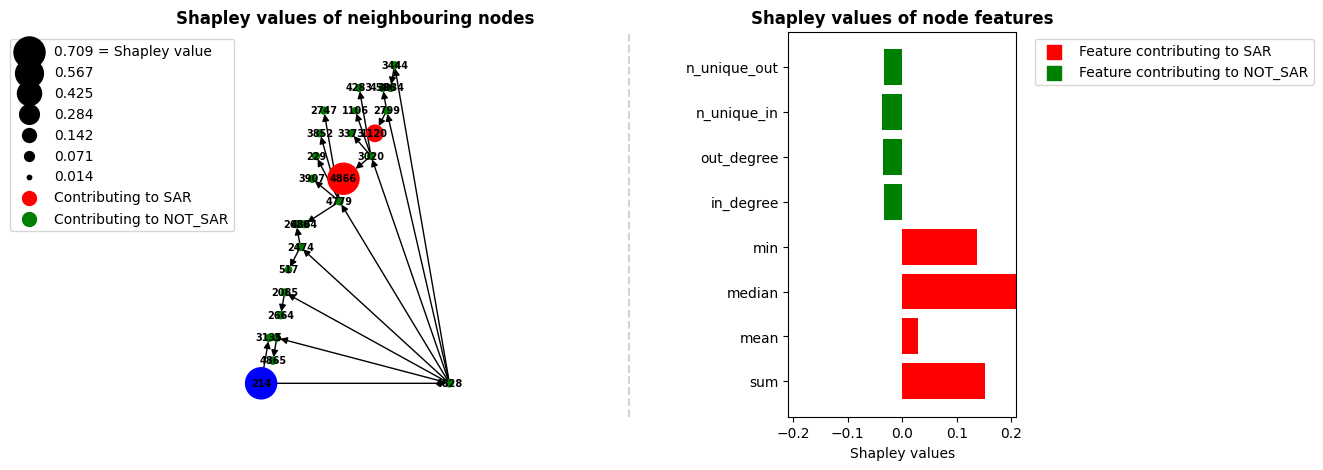

In [34]:
import networkx as nx
import matplotlib.pyplot as plt
from torch_geometric.utils import to_networkx



G = to_networkx(data)

# --- Printing information about node prediction ---
print(f'Explaining node {node_to_explain} which was prediced SAR.')
print(f'The node was predicted SAR (label 1) with probability {model.forward(testdata.x, testdata.edge_index)[node_to_explain].exp()[1].item():.4f}.')
print(f'The true label is {testdata.y[node_to_explain]}.\n')

# --- Extract Shapley values ---
F = explainer.F
D = explanations[0].shape[0] - F
SV = explanations[0]
SV_features = SV[:F]
SV_nodes = SV[F:]

# Node coloring
color_map = ['blue']
size_map = [500]
labels = {0: node_to_explain}
SV_max = np.abs(SV_nodes).max()
SV_min = np.abs(SV_nodes).min()
for i in range(len(SV_nodes)):
    SV_subgraph_index = org_to_new_mapping[explainer.neighbours[i].item()]    
    SV_node = SV_nodes[SV_subgraph_index-1]
    size_map.append(500 * np.abs(SV_node) / SV_max)
    labels[i+1] = new_to_org_mapping[i+1]
    if SV_node < 0:
        color_map.append('green')
    else: 
        color_map.append('red')

# Create figure
fig = plt.figure(figsize=(10, 5))

# --- Subplot for nodes ---
plt.subplot(1,3,1)

pos = nx.planar_layout(G)
#pos = nx.kamada_kawai_layout(G)
nx.draw(G, pos=pos, with_labels=True, labels=labels, node_color=color_map, node_size=size_map, font_size=7, font_weight='bold')

# Add legend
plt.scatter([], [], c='black', s=500, label=f'{SV_max:.3f} = Shapley value')
plt.scatter([], [], c='black', s=400, label=f'{4/5*SV_max:.3f}')
plt.scatter([], [], c='black', s=300, label=f'{3/5*SV_max:.3f}')
plt.scatter([], [], c='black', s=200, label=f'{2/5*SV_max:.3f}')
plt.scatter([], [], c='black', s=100, label=f'{1/5*SV_max:.3f}')
plt.scatter([], [], c='black', s=50, label=f'{50/500*SV_max:.3f}')
plt.scatter([], [], c='black', s=10, label=f'{10/500*SV_max:.3f}')
plt.scatter([], [], c='red', s=100, label='Contributing to SAR')
plt.scatter([], [], c='green', s=100, label='Contributing to NOT_SAR')
plt.legend(bbox_to_anchor=(0, 1),loc='upper right')

plt.title('Shapley values of neighbouring nodes',fontweight='bold')

# --- Add vertical line to separate the plots ---
plt.subplot(1, 3, 2)
plt.axvline(x=5, color='lightgray', linestyle='--')
plt.axis('off')  # Turn off axis

# --- Shapley Values for features ---
plt.subplot(1, 3, 3)
# Extract features that are used in the explanation, and get their original feature names
feat_idx, discarded_feat_idx = explainer.feature_selection(node_to_explain, "Expectation")
feature_names_in_explanation = [feature_names[i] for i in feat_idx]

colors = ['green' if e < 0 else 'red' for e in SV_features]
plt.barh(range(len(SV_features)), SV_features, color=colors)
xlim = np.abs(SV_features).max()
plt.xlim(-xlim, xlim)
plt.yticks(range(len(SV_features)), feature_names_in_explanation)
plt.xlabel('Shapley values')
plt.scatter([], [], c='red', s=100, marker = 's', label='Feature contributing to SAR')
plt.scatter([], [], c='green', s=100, marker = 's', label='Feature contributing to NOT_SAR')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title('Shapley values of node features',fontweight='bold')

# --- Plot figures ---
plt.show()

# GNNExplainer comparison

Node to explain: 214


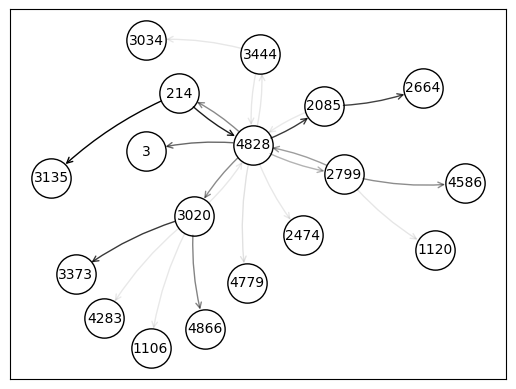

In [35]:
from torch_geometric.explain import Explainer, GNNExplainer

print(f'Node to explain: {node_to_explain}')

explainer = Explainer(
    model=model,
    algorithm=GNNExplainer(epochs=200),
    explanation_type='model',
    node_mask_type='attributes',
    edge_mask_type='object',
    model_config=dict(
        mode='multiclass_classification',
        task_level='node',
        return_type='probs',  # Model returns log probabilities.
    ),
)

explanation = explainer(testdata.x, testdata.edge_index, index=node_to_explain)

#explanation.visualize_feature_importance(top_k=10)
explanation.visualize_graph()

# LIME & SHAP for comparison

Starting forward_LIME...
Number of samples = 5000
Loading data...
number of graphs = 5000
Loading data into a single batch...
Starting forward pass...
out_tmp.shape = torch.Size([45000, 2])
Extracting output...
Finished.


[1824.59     608.19666  556.98     177.99986  806.19     461.42
    3.         0.         2.         0.     ]
Starting forward_LIME...
Number of samples = 20
Loading data...
number of graphs = 20
Loading data into a single batch...
Starting forward pass...
out_tmp.shape = torch.Size([180, 2])
Extracting output...
Finished.
Starting forward_LIME...
Number of samples = 1
Loading data...
number of graphs = 1
Loading data into a single batch...
Starting forward pass...
out_tmp.shape = torch.Size([9, 2])
Extracting output...
Finished.
Starting forward_LIME...
Number of samples = 20440
Loading data...
number of graphs = 20440
Loading data into a single batch...
Starting forward pass...
out_tmp.shape = torch.Size([183960, 2])
Extracting output...
Finished.


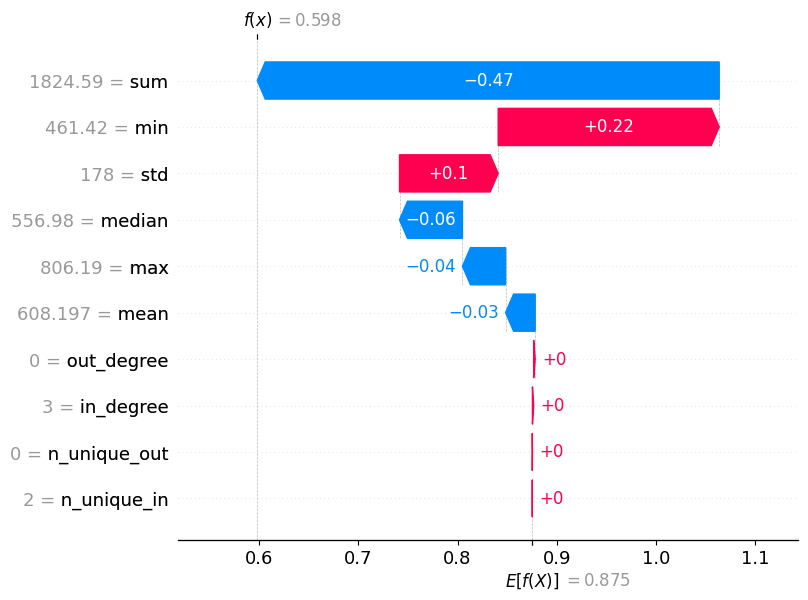

In [31]:
# --- Prepare model for NFVinput ---
data, org_to_new_mapping, new_to_org_mapping=utils.build_subgraph(testdata, node_to_explain, 3)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#data.edge_index = data.edge_index.to(device)
data = data.to(device)

# --- LIME ---
num_features = 10
class_prob_fn = model.forward_NFVinput

# Prepare the model for handling the LIME explainer
model.set_test_data(data)
model.set_node_to_explain(org_to_new_mapping[node_to_explain])

exp_LIME = LIME_explanation(node_to_explain = node_to_explain,
                                    num_features = num_features,
                                    class_prob_fn = class_prob_fn,
                                    testdata = testdata,
                                    feature_names = feature_names,
                                    target_names = target_names)

exp_LIME.show_in_notebook(show_table=True, show_all=False)


# --- SHAP ---
K = 20
class_prob_fn = model.forward_NFVinput

exp_SHAP = SHAP_explanation(node_to_explain = node_to_explain,
                                         class_prob_fn = class_prob_fn,
                                         backgrounddata = traindata,
                                         explaindata = testdata,
                                         feature_names = feature_names,
                                         K = K)

shap.plots.waterfall(exp_SHAP[0])

# Old stuff, maybe delete later

In [8]:
# --- OLD STUFF, MAYBE DELETE LATER ---

# - Extracting Shapley values and printing some information -
# print(type(explanations))
# print(len(explanations))
# print(type(explanations[0]))
# print(explanations[0].shape)

# F = explainer.F
# D = explanations[0].shape[0] - F
# SV = explanations[0]
# SV_features = SV[:F]
# SV_nodes = SV[F:]

# print(f'Sum of SV_features: {SV_features.sum()}')
# print(f'Sum of SV_nodes: {SV_nodes.sum()}')

# _, idxs = torch.topk(torch.from_numpy(np.abs(SV)), 6)
# print(idxs)
# for i in idxs:
#     if i < F:
#         print(f'Feature {i} has SV {SV[i]}')
#     else:
#         print(f'Node {explainer.neighbours[i - F]} has SV {SV[i]}')


# - Plotting node feature shapley values -
# # Extract features that are used in the explanation, and get their original feature names
# feat_idx, discarded_feat_idx = explainer.feature_selection(node_to_explain, "Expectation")
# print(f'Feature indices: {feat_idx}\nDiscared feature indices: {discarded_feat_idx}')
# feature_names_in_explanation = [feature_names[i] for i in feat_idx]

# colors = ['green' if e < 0 else 'red' for e in SV_features]
# plt.barh(range(len(SV_features)), SV_features, color=colors)
# plt.xlim(-0.75, 0.75)
# plt.yticks(range(len(SV_features)), feature_names_in_explanation)
# plt.xlabel('SV_features')
# plt.ylabel('Features')
# plt.title('SV_features Bar Plot')
# plt.scatter([], [], c='red', s=300, label='Feature contributing to SAR')
# plt.scatter([], [], c='green', s=300, label='Feature contributing to NOT_SAR')
# plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
# plt.show()


# - Comparing the number of ingoing and outgoing neighbours for SAR predictions -
# def get_sar_prediction_ix(model, testdata):
#     model.eval()
#     with torch.no_grad():
#         out = model.forward(testdata.x, testdata.edge_index)
#         y_pred = out.argmax(dim=1)
#         sar_prediction_ix = torch.where(y_pred == 1)[0]
#     return sar_prediction_ix

# sar_prediction_ix = get_sar_prediction_ix(model, testdata)
# n_sar_prediction_ix = len(sar_prediction_ix)

# Checking the number of ingoing (edges going towards the node v) and outgoing (edges going away from the node v) neighbours.
# sar_prediction_n_outgoing_neighbours = []
# sar_prediction_n_ingoing_neighbours = []
# for count, v in enumerate(sar_prediction_ix):
#     outgoing_neighbour_ix = torch.where(testdata.edge_index[0] == v)
#     ingoing_neighbour_ix = torch.where(testdata.edge_index[1] == v)
#     outgoing_neighbour_ix = testdata.edge_index[1][outgoing_neighbour_ix]
#     ingoing_neighbour_ix = testdata.edge_index[0][ingoing_neighbour_ix]
#     n_outgoing_neighbours = len(outgoing_neighbour_ix)
#     n_ingoing_neighbours = len(ingoing_neighbour_ix)
#     sar_prediction_n_outgoing_neighbours.append(n_outgoing_neighbours)
#     sar_prediction_n_ingoing_neighbours.append(n_ingoing_neighbours)

# n_check = 20
# print(sar_prediction_n_ingoing_neighbours[:n_check])
# print(sar_prediction_n_ingoing_neighbours[-n_check:])
# print(sar_prediction_n_outgoing_neighbours[:n_check])
# print(sar_prediction_n_outgoing_neighbours[-n_check:])

# import matplotlib.pyplot as plt

# data_range_outgoing = max(sar_prediction_n_outgoing_neighbours) - min(sar_prediction_n_outgoing_neighbours)
# data_range_ingoing = max(sar_prediction_n_ingoing_neighbours) - min(sar_prediction_n_ingoing_neighbours)

# plt.figure(figsize=(10, 5))

# # Histogram for outgoing_neighbours
# plt.subplot(1, 2, 2)
# plt.hist(sar_prediction_n_outgoing_neighbours, bins=data_range_outgoing, color='green')
# plt.xlabel('Number of Outgoing Neighbours')
# plt.ylabel('Frequency')
# plt.title('Histogram of Outgoing Neighbours')

# # Histogram for ingoing_neighbours
# plt.subplot(1, 2, 1)
# plt.hist(sar_prediction_n_ingoing_neighbours, bins=data_range_ingoing, color='blue')
# plt.xlabel('Number of Ingoing Neighbours')
# plt.ylabel('Frequency')
# plt.title('Histogram of Ingoing Neighbours')

# plt.tight_layout()
# plt.show()

# print(f'max number of outgoing neighbours: {max(sar_prediction_n_outgoing_neighbours)}')
# print(f'max number of ingoing neighbours: {max(sar_prediction_n_ingoing_neighbours)}')


# --- Checking corectness of subgraph ---
# --- Checking that the subgraph is correct ---
# from torch_geometric.utils import k_hop_subgraph
# from torch_geometric.data import Data
# subset, edge_index, mapping, edge_mask = k_hop_subgraph(node_to_explain, 3, testdata.edge_index, relabel_nodes=True)

# x = testdata.x[subset,:]
# edges = testdata.edge_index[:, edge_mask]
# d = Data(x,edges)
# print(subset)
# print(x.shape)
# print(edges.shape)

# labels = {}
# for e in subset:
#     labels[e.item()] = e.item()

# plt.figure(figsize=(10, 5))
# plt.subplot(1,2,1)
# G = to_networkx(d)
# pos = nx.planar_layout(G)
# nx.draw(G, pos=pos, with_labels=True, labels=labels, font_size=7, font_weight='bold')
# plt.show()

# # --- Agnes implementation, jämförelse ---
# plt.subplot(1,2,2)
# G = to_networkx(data)
# pos = nx.planar_layout(G)

# labels = {}
# for new_node_ix in range(data.x.shape[0]):
#     orig_node_ix = new_to_org_mapping[new_node_ix]
#     labels[new_node_ix] = orig_node_ix
#     print(new_node_ix)
#     print(orig_node_ix)

# nx.draw(G, pos=pos, with_labels=True, labels=labels, font_size=7, font_weight='bold')
# plt.show()